# Площадь под графиком и управление порогом
### Цель работы
Научиться применять кривые PR и ROC для оценки моделей классификации, использовать их для выбора оптимального порога
классификации

#### Содержание работы

1. Сгенерируйте датасет для бинарной классификации, обучите на нем модель логистической регрессии и постройте для этой модели кривые ROC и PR.
2. Вычислите для этой модели метрики площади под кривыми (ROC-AUC и PR-AUC).
3. Обучите на том же датасете другую модель и сравните ее эффективность по кривым и по метрикам.
4. Сгенерируйте датасет для бинарной классификации с большим дисбалансом классов, обучите на нам ту же модель и постройте кривые.
5. Используйте данные, вычисленные для построения кривых для нахождения оптимального значения порога модели. Постройте матрицу классификации для модели с порогом по умолчанию и с лучшим порогом. Сравните результаты.

#### Задания для самостоятельного выполнения

1. Повторите анализ из лабораторной работы, но с двумерными датасетами. Изобразите графически, как изменение порога влияет на расположение границы принятия решений.
2. Повторите анализ на реальном датасете для бинарной классификации. Проинтерпретируйте результат, сделайте вывод.
3. В задании по оптимизации порога используйте ROC и среднее геометрическое между TPR и FPR как критерий оптимизации.
4. При оптимизации порога по PR-кривой используйте другую F-метрику - сначала с преимуществом precision, а затем - с превалированием recall. Изобразите получившиеся пороги на графике. Проанализируйте метрики получившихся моделей.
5. Постройте классификационные кривые для задачи множественной классификации. Проинтерпретируйте результат.
6. Используйте для построения кривых библиотеку _yellowbrick_. 

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc, average_precision_score
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier

In [38]:
# Генерация искусственного датасета
X, y = make_classification(n_samples=1000, n_features=20, n_classes=2, random_state=1)

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=2)

# Обучение модели логистической регрессии
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

Логистическая регрессия, наряду со многими другими моделями классификации может работать как точечный предиктор (то есть выдавать для входного объекта наиболее вероятный класс), а может - как вероятностный (то есть для данного объекта выдавать оценки вероятности принадлежности к каждому классу, который присутствует в обучающей выборке).

In [39]:
# Предсказание вероятностей классов для тестового набора данных
y_proba = model.predict_proba(X_test)[:, 1]
y_proba

# Получена матрица вероятностей:

array([9.95972685e-01, 9.97994843e-01, 5.29883066e-03, 1.52374194e-01,
       9.98333350e-01, 5.00061448e-01, 1.97631392e-02, 2.34633843e-02,
       9.82000697e-01, 7.06465180e-01, 4.16201961e-03, 7.46446600e-01,
       7.66567488e-03, 9.61958719e-01, 9.35214568e-01, 8.07653554e-01,
       1.44803886e-01, 9.56532321e-01, 1.56957507e-01, 9.44908759e-01,
       8.67007620e-01, 4.10282064e-01, 2.04815673e-02, 6.67093752e-01,
       4.26334713e-03, 9.56694469e-01, 6.92577362e-01, 9.94406759e-01,
       2.49159988e-02, 5.50542684e-01, 7.92214513e-01, 8.15242298e-01,
       8.18291856e-02, 8.23317999e-01, 1.53516867e-02, 7.98798532e-02,
       9.87551937e-01, 9.36923464e-01, 9.86339822e-01, 3.19318661e-01,
       9.82576369e-03, 3.82722802e-02, 9.83635286e-02, 9.83780221e-01,
       6.53737641e-03, 5.29530623e-01, 5.01616608e-01, 9.97760930e-01,
       8.40960809e-03, 1.42082825e-01, 2.21934800e-02, 6.47786780e-01,
       9.79115074e-01, 2.32942383e-01, 5.09205311e-02, 9.03776284e-01,
      

В этой матрице количество строк совпадает с количеством объектов, которые мы передали методу (в данном случае мы передали всю тестовую выборку). Для каждого объекта в матрице указано два значения - вероятности его отнесения, по мнению модели, соответственно, к отрицательному и положительному классу. Так как задача у нас бинарная, можно заметить, что эти два числа всегда дают в сумме единицу. В общем случае, для множественной классификации, это не обязательно выполняется.

Для построения кривой ROC используем встроенную в sklearn функцию roc_curve, которая находится в пакете metrics:

In [40]:
# Вычисление ROC кривой
fpr, tpr, thresholds_roc = roc_curve(y_test, y_proba)
roc_auc = roc_auc_score(y_test, y_proba)

Данная функция возвражает три массива: значения метрики FPR (false positive rate), TPR (true positive rate) и значение порога. Фактически, данная функция берет определенное количество значений порога (в промежутке от 0 до 1), применяет данный порог для точной классификации, исходя из переданной ей матрицы вероятностей, и вычисляет при данном значении порога две упомянутые метрики.

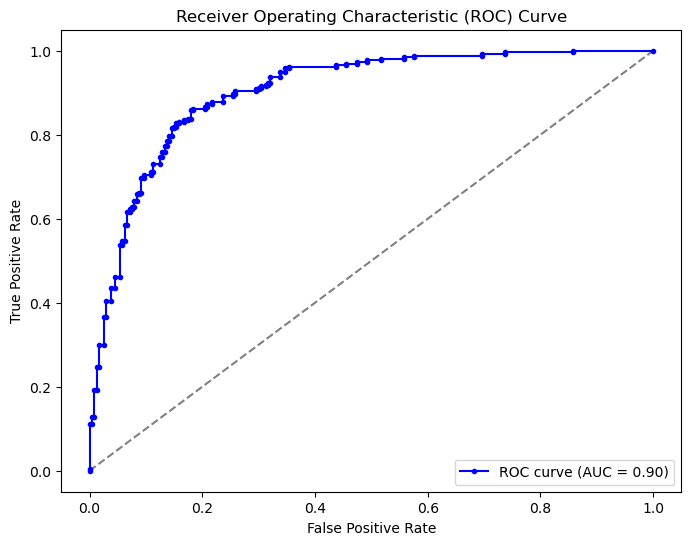

In [41]:
# Визуализация ROC кривой
plt.figure(figsize=(8, 6))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.plot(fpr, tpr, marker='.', color='blue', label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [42]:
# Метрика ROC-AUC, измеряющая площадь под графиком данной кривой

roc_auc_score(y_test, y_proba)

0.9028205128205128

Из графика мы видим, что кривая находится выше прямой, что свидетельствует о том, что классификатор работает лучше, чем случайное предсказание. Но можно заметить, что при разных значениях порога ( точки на графике) модель имеет значительно различающиеся характеристики. 

Анализ графика может дать только примерное представление о том, насколько хороша модель. Более четкую оценку даст метрика ROC-AUC, измеряющая площадь под графиком данной кривой. 

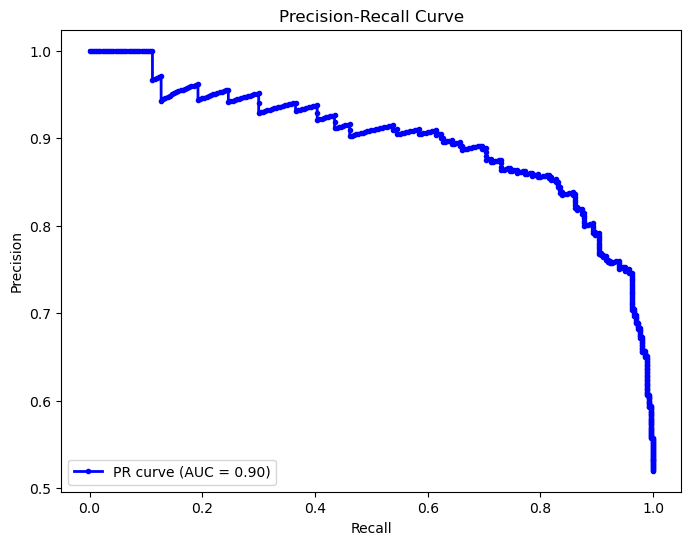

In [43]:
# Вычисление PR кривой
precision, recall, thresholds_pr = precision_recall_curve(y_test, y_proba)
pr_auc = auc(recall, precision)

# Визуализация PR кривой
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', color='blue', lw=2, label='PR curve (AUC = %0.2f)' % pr_auc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [44]:
# Численная метрика - площадь под графиком PR-кривой - PR-AUC

auc(recall, precision)

0.8977244980325834

In [45]:
# Отчет о классификации по данной модели

y_test_pred = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.83      0.82      0.83       240
           1       0.84      0.85      0.84       260

    accuracy                           0.83       500
   macro avg       0.83      0.83      0.83       500
weighted avg       0.83      0.83      0.83       500


Данный отчет характеризует поведение модели только в одной точке - при значении порога, равном по умолчанию 0,5. Кривые же показывают, как модель будет работать при все возможных значениях порога.

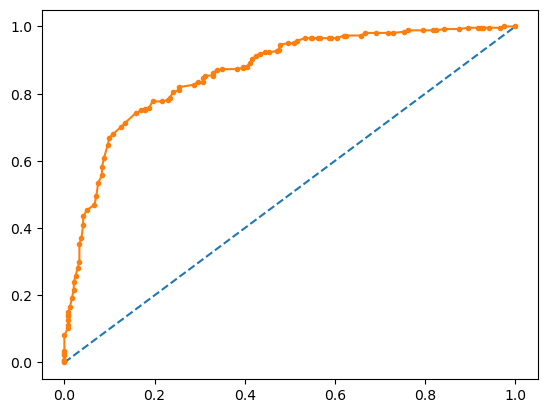

In [46]:
# Для сравнения попробуем обучить на этих же данных другую модель. 
# Метод ближайших соседей.
model2 = KNeighborsClassifier(n_neighbors=250).fit(X_train, y_train)
y_pred2_proba = model2.predict_proba(X_test)
fpr, tpr, _ = roc_curve(y_test, y_pred2_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()

In [47]:
roc_auc_score(y_test, y_pred2_proba[:, 1])

#ROC-AUC второй модели значительно хуже - 86,3%

0.8630608974358974

### Дисбаланс классов

Наиболее явно различия между этими двумя классификационными кривыми - ROC и PR - демонстрирует пример с большим дизбалансом классов. Cгенерируем датасет, в котором объектов разных классов не примерно равное количество, как в предыдущем примере, а объектов отрицательного класса, скажем, 99%. 

In [72]:
X, y = make_classification(n_samples=1000, n_classes=2, weights=[0.99, 0.01], random_state=1)

In [73]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=4)

print('Датасет: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Обучающая: Class0=%d, Class1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Тестовая: Class0=%d, Class1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

Датасет: Class0=985, Class1=15
Обучающая: Class0=490, Class1=10
Тестовая: Class0=495, Class1=5


Видно, что в одной половине выборки положительных объектов в два раза больше, чем в другой. При случайном разделении, если есть сильно миноритарные классы, можно например случайно получить выборку, в которой какие-то классы не представлены вообще. Для предотвращения таких случаев нужно воспользоваться стратификацией:

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, stratify=y)

Это аргумент следит за тем, чтобы в обоих частях выборки распределение переданного атрибута было примерно такое же, как и целом датасете.

In [75]:
print('Датасет: Class0=%d, Class1=%d' % (len(y[y==0]), len(y[y==1])))
print('Обучающая: Class0=%d, Class1=%d' % (len(y_train[y_train==0]), len(y_train[y_train==1])))
print('Тестовая: Class0=%d, Class1=%d' % (len(y_test[y_test==0]), len(y_test[y_test==1])))

Датасет: Class0=985, Class1=15
Обучающая: Class0=493, Class1=7
Тестовая: Class0=492, Class1=8


Распределение уже гораздо более равномерное. Для стратификации можно задавать любой массив, не обязательно значение целевой переменной, и разделение произойдет так, чтобы сохранить распределение, заданное в этом массиве.

Точно также, как и в предыдущем примере, обучим модель и сразу вычислим матрицу вероятностей:

In [76]:
model = LogisticRegression().fit(X_train, y_train)
y_proba = model.predict_proba(X_test)

y_test = model.predict(X_test)
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       497
           1       0.00      0.00      0.00         3

    accuracy                           0.99       500
   macro avg       0.50      0.50      0.50       500
weighted avg       0.99      0.99      0.99       500


/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/juliamekhtieva/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Мажоритарный класс (в данном случае - отрицательный, он у нас в большинстве) распознается очень хорошо, а миноритарный - очень плохо. В нашем случае, вообще по положительному классу все метрики нулевые. Общая точность (accuracy) модели весьма приемлема - 98%. Дисбаланс классов "скрывает" в точности недостатки работы модели.

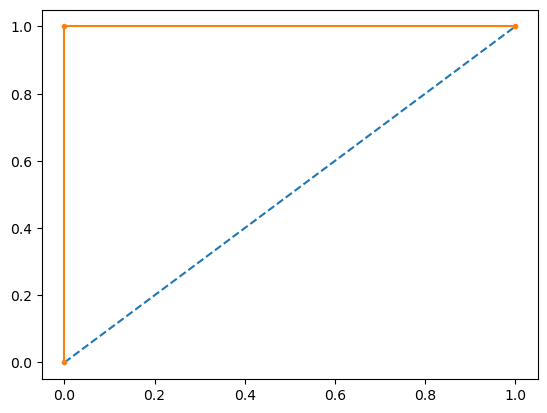

In [71]:
# ROC данной модели

fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])

plt.plot([0, 1], [0, 1], linestyle='--')
plt.plot(fpr, tpr, marker='.')
plt.show()